# **Dataiku Data Scientist Technical Assessment**
### Author : Jules Boistard
### Submission date : January 18th, 2022
___

#### **#1 : Exploratory data analysis**

##### **1.1 : Importing the dataset**

In [2]:
# Read the train and test files
import pandas as pd
import re

metadata = open("data/census_income_metadata.txt")
col_names = [re.findall("\(([^\)]+)\)", line)[0] for line in metadata.readlines()[81:121]]
col_names.append("total person income")

train = pd.read_csv("data/census_income_learn.csv", header=None, sep=", ", na_values="?", usecols=[i for i in range(42) if i!=24], names=col_names)
test = pd.read_csv("data/census_income_test.csv", header=None, sep=", ", na_values="?", usecols=[i for i in range(42) if i!=24], names=col_names)

'''
Note : column #24 in the csv corresponds to the instance weight.
While it will be kept for exploratory data analysis, we will later on remove it to train the classifiers.
It is therefore treated separately in this section and added as last column.
'''
train["instance weight"] = pd.read_csv("data/census_income_learn.csv", header=None, sep=", ", na_values="?", usecols=[24])
test["instance weight"] = pd.read_csv("data/census_income_test.csv", header=None, sep=", ", na_values="?", usecols=[24])

##### **1.2 : Identify duplicates and conflicts in data**

As stated in the metadata file, the train and test sets respectively contains a fairly large number of duplicates or conflictided instances, precisely :
- 46716 obervations for the train set
- 20936 observations for the test set

This can be easily verified, as shown below, counting duplicates while excluding instance weight and target variable

In [3]:
nb_dc_train = train.drop(["instance weight", "total person income"], axis=1).duplicated().sum()
nb_dc_test  = test.drop(["instance weight", "total person income"], axis=1).duplicated().sum()
print("Number of duplicates/conflicts in train set : ", nb_dc_train)
print("Number of duplicates/conflicts in test set : ", nb_dc_test)
print ("Total number of duplicates : ", nb_dc_train + nb_dc_test)

Number of duplicates/conflicts in train set :  46716
Number of duplicates/conflicts in test set :  20936
Total number of duplicates :  67652


We need to adress this issue right away, as it could potentially hurt our analysis and machine learning model a lot later on. We can go a little bit further by dissociating actual duplicates (identical observations with same target) from conflicts (identical observations with different targets)

In [4]:
dc_train = train.drop(["instance weight", "total person income"], axis=1).duplicated()
duplicates_train = train.drop(["instance weight"], axis=1).duplicated()
conflicts_train = (dc_train & ~duplicates_train)

dc_test= test.drop(["instance weight", "total person income"], axis=1).duplicated()
duplicates_test = test.drop(["instance weight"], axis=1).duplicated()
conflicts_test = (dc_test & ~duplicates_test)

print("Number of duplicate/conflicts over whole dataset : ", dc_train.sum() + dc_test.sum())
print("- Including ", duplicates_train.sum(), " duplicates in train set")
print("- Including ", conflicts_train.sum(), " conflicts in train set")
print("- Including ", duplicates_test.sum(), " duplicates in train set")
print("- Including ", conflicts_test.sum(), " conflicts in train set")


Number of duplicate/conflicts over whole dataset :  67652
- Including  46627  duplicates in train set
- Including  89  conflicts in train set
- Including  20898  duplicates in train set
- Including  38  conflicts in train set


Let us look at an example of a duplicate entry (in the train set)

In [5]:
pd.set_option('display.max_columns', 50)

random_duplicate_idx = duplicates_train[duplicates_train].sample(random_state=5).index
ref_entry = train.iloc[random_duplicate_idx]
df_sample = train.copy()
for col in train.drop(["instance weight"], axis=1).columns:
    ref_value = ref_entry[col].iloc[0]
    if not pd.isnull(ref_value):
        df_sample = df_sample[df_sample[col] == ref_value]
df_sample

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,race,hispanic origin,sex,member of a labor union,reason for unemployment,full or part time employment stat,capital gains,capital losses,dividends from stocks,tax filer stat,region of previous residence,state of previous residence,detailed household and family stat,detailed household summary in household,migration code-change in msa,migration code-change in reg,migration code-move within reg,live in this house 1 year ago,migration prev res in sunbelt,num persons worked for employer,family members under 18,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,total person income,instance weight
137373,13,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,South,Utah,Child <18 never marr not in subfamily,Child under 18 never married,MSA to MSA,Same county,Same county,No,Yes,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.,2738.79
197426,13,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,South,Utah,Child <18 never marr not in subfamily,Child under 18 never married,MSA to MSA,Same county,Same county,No,Yes,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.,3040.58


We can see from the above example that there are 2 identical entries, **target variable included** (it could be a lot more than 2).

To delete duplicates, we can merge these lines and add up the instance weights, in the training set and test set separately

In [6]:
train_without_duplicates = train.groupby([col for col in train.drop(["instance weight"], axis=1).columns],dropna=False)["instance weight"].sum().reset_index()
test_without_duplicates = test.groupby([col for col in test.drop(["instance weight"], axis=1).columns],dropna=False)["instance weight"].sum().reset_index()


# Quick verification that we have exactly the initial number of entries minus the previously identified number of duplicates in each set
print("Dropped entries for train set : ", len(train) - len(train_without_duplicates))
print("Dropped entries for test set : ", len(test) - len(test_without_duplicates))

Dropped entries for train set :  46627
Dropped entries for test set :  20898


Let us now look at an example of conflicting instances in data (in the train set still)

In [7]:
# Since indexes have been reset in the previous operation, we need to re-compute the indexes of conflicting instances
conflicts_train = train_without_duplicates.drop(["instance weight", "total person income"], axis=1).duplicated()
conflicts_test = test_without_duplicates.drop(["instance weight", "total person income"], axis=1).duplicated()

print(conflicts_train.sum())
print(conflicts_test.sum())

89
38


In [8]:
random_conflict_idx = conflicts_train[conflicts_train].sample(random_state=5).index
ref_entry = train_without_duplicates.iloc[random_conflict_idx]
df_sample = train_without_duplicates.copy()
for col in train_without_duplicates.drop(["instance weight", "total person income"], axis=1).columns:
    ref_value = ref_entry[col].iloc[0]
    if not pd.isnull(ref_value):
        df_sample = df_sample[df_sample[col] == ref_value]
df_sample

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,race,hispanic origin,sex,member of a labor union,reason for unemployment,full or part time employment stat,capital gains,capital losses,dividends from stocks,tax filer stat,region of previous residence,state of previous residence,detailed household and family stat,detailed household summary in household,migration code-change in msa,migration code-change in reg,migration code-move within reg,live in this house 1 year ago,migration prev res in sunbelt,num persons worked for employer,family members under 18,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,total person income,instance weight
123946,58,Private,32,18,Some college but no degree,0,Not in universe,Married-civilian spouse present,Wholesale trade,Sales,White,All other,Male,Not in universe,Not in universe,Full-time schedules,0,0,0,Joint both under 65,Not in universe,Not in universe,Householder,Householder,NaN,NaN,NaN,Not in universe under 1 year old,NaN,6,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,95,- 50000.,3349.55
123947,58,Private,32,18,Some college but no degree,0,Not in universe,Married-civilian spouse present,Wholesale trade,Sales,White,All other,Male,Not in universe,Not in universe,Full-time schedules,0,0,0,Joint both under 65,Not in universe,Not in universe,Householder,Householder,NaN,NaN,NaN,Not in universe under 1 year old,NaN,6,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,95,50000+.,2285.73


This time, every thing is identical except for the target value (total person income). Since we want to avoid conflicting instances, we can keep the one with the highest instance weight for each group of n conflicting observations (this would be the first row in the above example)

In [9]:
train_without_dc = train_without_duplicates.sort_values(
    "instance weight",
    ascending=False
).drop_duplicates(
    subset=list(train_without_duplicates.drop(["instance weight", "total person income"],axis=1).columns),
    keep="first"
)

test_without_dc = test_without_duplicates.sort_values(
    "instance weight",
    ascending=False
).drop_duplicates(
    subset=list(test_without_duplicates.drop(["instance weight", "total person income"],axis=1).columns),
    keep="first"
)

# Quick verification that we have exactly the initial number of entries minus the previously identified number of conflicts in each set
print("Dropped entries for train set : ", len(train_without_duplicates) - len(train_without_dc))
print("Dropped entries for test set : ", len(test_without_duplicates) - len(test_without_dc))

Dropped entries for train set :  89
Dropped entries for test set :  38


In [10]:
print("Train set drop rate : ", 100 * round(1-len(train_without_dc)/len(train), 2), "%")
print("Test set drop rate : ", 100 * round(1-len(test_without_dc)/len(test), 2), "%")

Train set drop rate :  23.0 %
Test set drop rate :  21.0 %


We dropped a little less than a quarter of our initial dataset, which is acceptable.

We will save the "cleaned" train and test sets for future pre processing and model training

For the rest of exploratory data analysis, let us concatenate them to look at statistics on the whole dataset

In [11]:
train_without_dc.to_csv("data/train_clean.csv", index=False)
test_without_dc.to_csv("data/test_clean.csv", index=False)

data = pd.concat([train_without_dc, test_without_dc], ignore_index=True)

##### **1.3 : Looking into missing values**

In [12]:
# Identify categorical columns in the dataset (pre-identified in metadata file)
num_cols = ["age", "wage per hour", "capital gains", "capital losses", "dividends from stocks", "num persons worked for employer", "weeks worked in year"]
cat_cols = [col for col in train.columns if col not in num_cols and col not in ["total person income", "instance weight"]]

<AxesSubplot:>

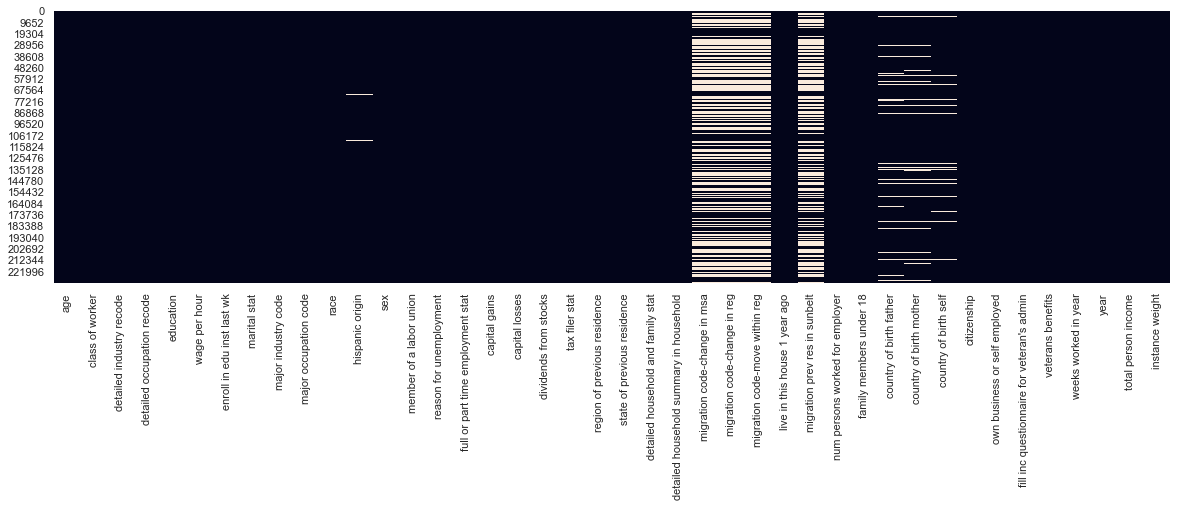

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

plt.figure(figsize=(20,5))
sns.heatmap(data.isna(), cbar=False)

In [14]:
nan_rate = data.isna().sum() / len(data)
nan_rate.sort_values(ascending=False).head(10)

migration code-change in msa      0.491053
migration code-change in reg      0.491053
migration code-move within reg    0.491053
migration prev res in sunbelt     0.491053
country of birth father           0.041833
country of birth mother           0.037900
country of birth self             0.021832
hispanic origin                   0.005349
state of previous residence       0.004425
citizenship                       0.000000
dtype: float64

From the above, we can separate the 9 variables with missing values into 2 groups :
- Top 4 : they have near 50% of missing values, so we will probably drop them altogether in preprocessing later on
- Bottom 5 : they have a rather low rate of missing values, therefore imputation could be a viable option (arguably, the middle 3 could also be dropped as the missing rate is not quite negligible)

##### **1.4 : Continuous variables distribution**

In [15]:
# Look at descriptive stats for numerical features
data[num_cols].describe()

,age,wage per hour,capital gains,capital losses,dividends from stocks,num persons worked for employer,weeks worked in year
count,231633.000000,231633.000000,231633.000000,231633.000000,231633.000000,231633.000000,231633.000000
mean,39.649778,71.195633,557.797546,47.592528,252.539038,2.514780,29.786205
std,19.782461,308.852750,5302.590688,305.700022,2198.239468,2.404797,23.839211
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,38.000000,0.000000,0.000000,0.000000,0.000000,2.000000,44.000000
75%,53.000000,0.000000,0.000000,0.000000,0.000000,5.000000,52.000000
max,90.000000,9999.000000,99999.000000,4608.000000,99999.000000,6.000000,52.000000


We can detect a couple of things from the above statistics :
- Wage, capital gains (and losses ?) and dividends seem to have been capped @ 9999 and 99999
- The nb of persons working for employer seem strangely low, which seems to indicate that the data have been altered
- The average worked weeks seem very low, probably accounting for children and retired people in the sample

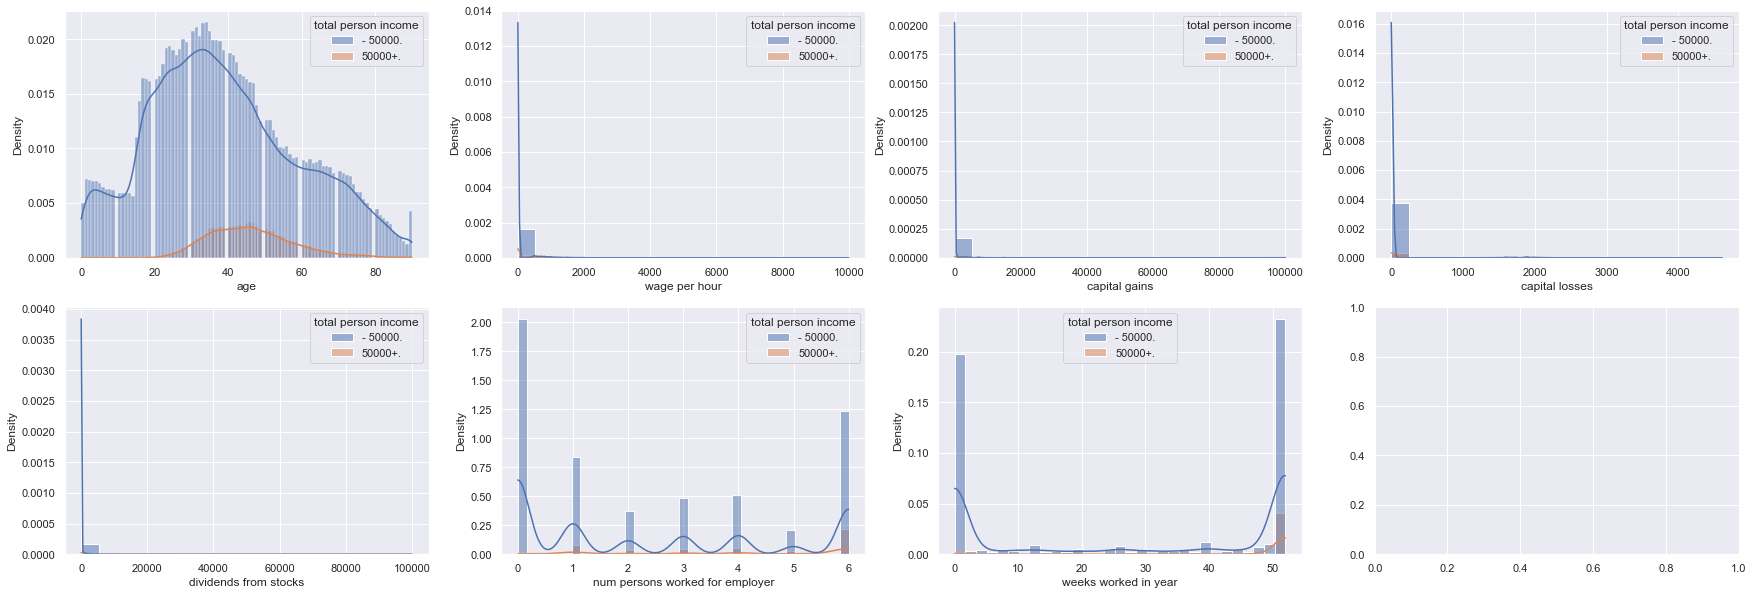

In [16]:
# Show density plot for all the continuous variables
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(30, 10))
for i, col in enumerate(num_cols):
    sns.histplot(data, x=col, hue="total person income", stat="density", kde=True, ax=axs.flatten()[i])

In [17]:
print((data["wage per hour"] == 0).sum()/len(data))
print((data["capital gains"] == 0).sum()/len(data))
print((data["capital losses"] == 0).sum()/len(data))
print((data["dividends from stocks"] == 0).sum()/len(data))

0.9271001972948587
0.9521052699744855
0.974904266663213
0.8636075170636308


- **Age** : a rather nice gaussian distribution which seems to be centered around 30-40 depending on the target class (which is interesting in itself), we probably won't have to wrangle much with this feature

- **Wage per hour, capital gains, capital losses, dividends from stocks** : these are **highly skewed** distributions with an overwhelmingly large number of zeros (between 86 and 97% of observations). We might consider dropping these features later on or, alternatively, replace them with binary ones (null or not null)

- **Num persons worked for employer** : the plot makes it obvious that the initial range of wages has been mapped to a discrete set of values. While we could treat this as a categorical variable, the documentation indicates that the higher the assigned value, the higher the number of people working for employer. We can therefore keep it as it is.

- **Weeks worked in year** : we can see a U-shaped distribution. One the left side, the population might correspond to either children, pensioners or unemployed adults (which seems to be corroborated by the plot below). This feature could also be mapped to a binary variable (worked / did not work this year)

*Note : due to imbalance of target classes, color separation don't show much on the plots above, we will have a closer look at relationship between variables and target later on*

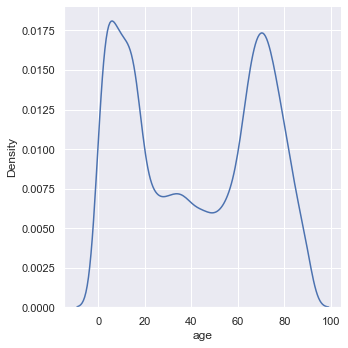

In [18]:
# This plot shows the age distribution for people who did not work during the year but are not identified as 'unemployed' either
sns.displot(data[(data["weeks worked in year"] == 0) & (data["reason for unemployment"] == "Not in universe")], x="age", kind="kde")

##### **1.5 : Distribution of categories for other features**

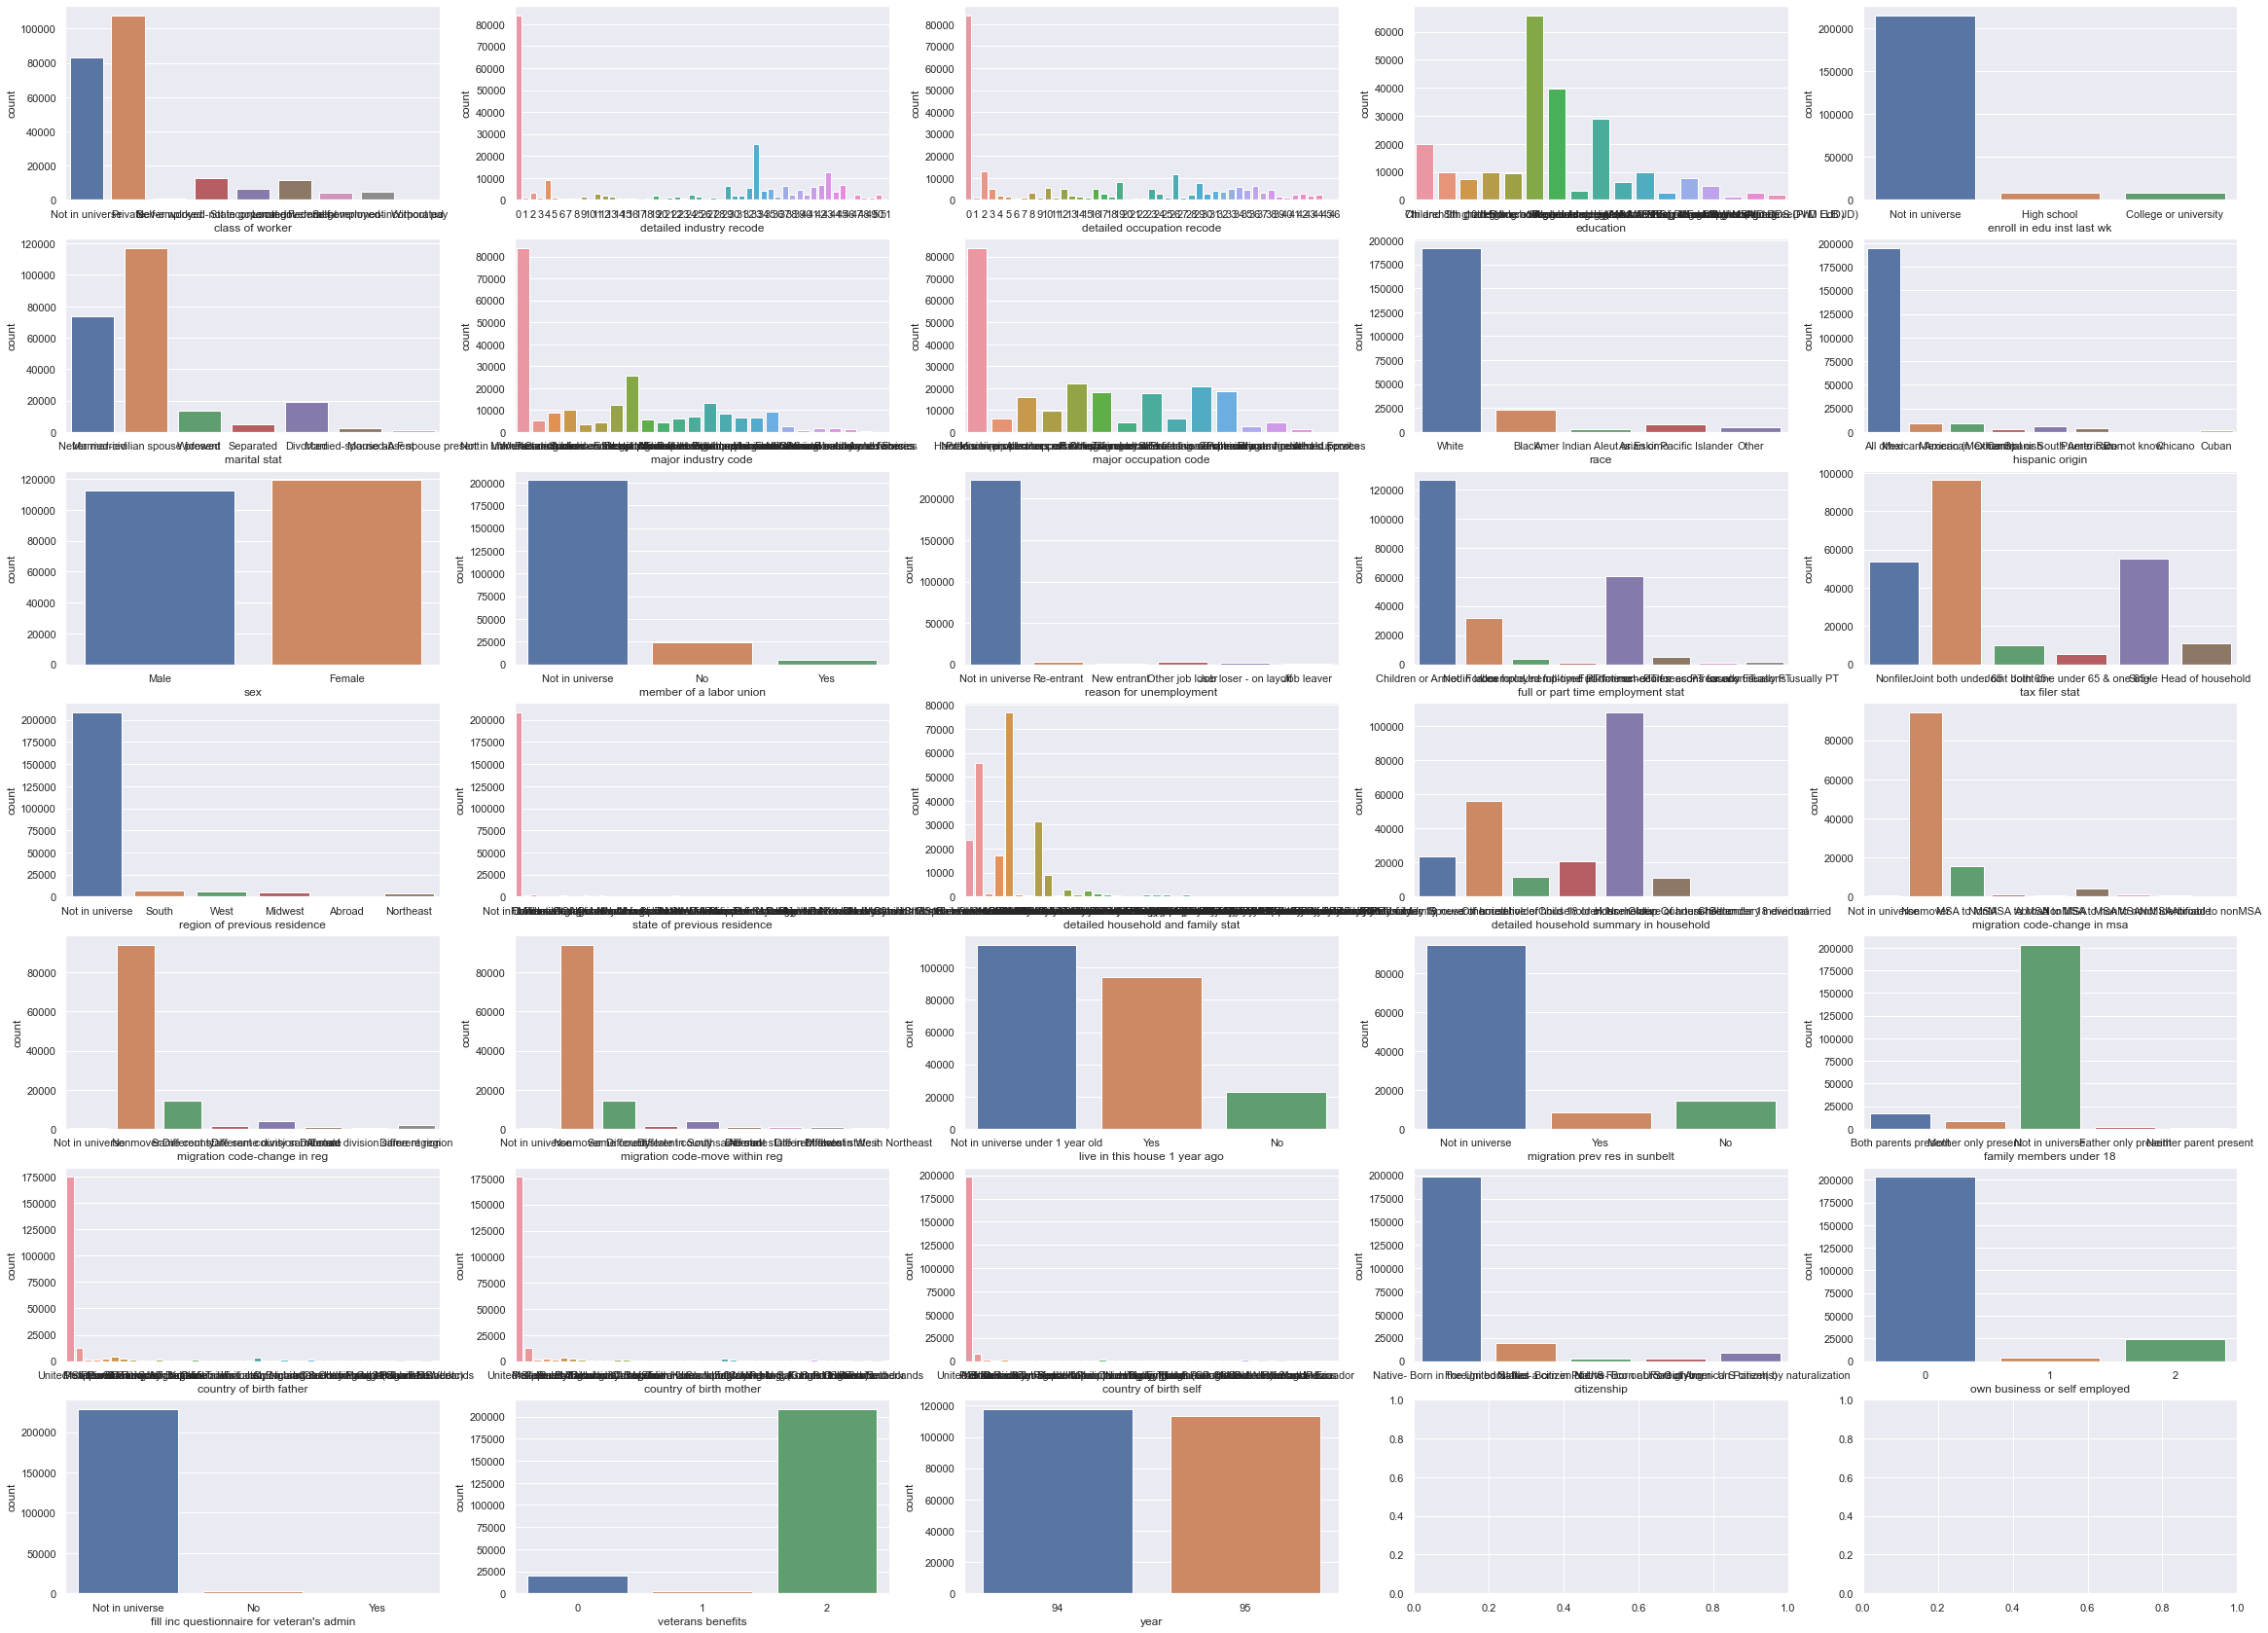

In [19]:
# Show bar charts for categorical features distribution
fig, axs = plt.subplots(nrows=7, ncols=5, figsize=(40, 30))
for i, col in enumerate(cat_cols):
    sns.countplot(data=data, x=col, ax=axs.flatten()[i])

- Some of these features are heavily unbalanced. To avoid ending up with a too large number of features when encoding later on, we could regroup all categories with frequency lower than an arbitrary threshold (for example 5%, which would be all categories below ~11k observations on the plots above)

- Additionnally, it is worth noting that the imbalance is too extreme in certain cases, which could lead to simply get rid of the features ("state of previous residence", for example)

##### **1.6 : Dependency between variables**

Let us first check correlation between continuous variables using pearson's coefficient (as seen before, the "number of employees" feature should be treated separately because it has been mapped to a discrete set of values)

<AxesSubplot:>

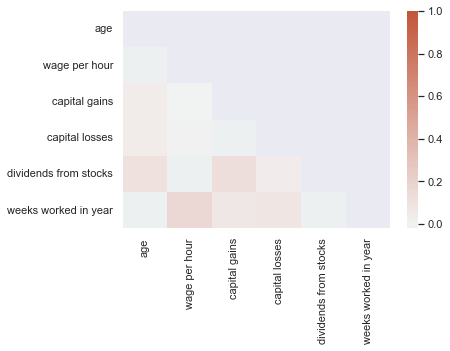

In [25]:
# Check correlation coefficient between continous variables
import numpy as np

corr = data[[col for col in num_cols if col != "num persons worked for employer"]].corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap, center=0, vmax=1, mask=mask)

There is no evidence of correlation between these features.

*TODO : dependencies among categorical variables and between cat and numerical variables*

##### **1.7 : Relationships between target and variables**

In [59]:
# Separating dataset based on output category
data_under50 = data[data["total person income"] == "- 50000."]
data_over50 = data[data["total person income"] == "50000+."]

In [62]:
# Distribution of target classes
print("Under 50k : " + str(len(data_under50)/len(data)))
print("Over 50k : " + str(len(data_over50)/len(data)))

Under 50k : 0.920283379311238
Over 50k : 0.07971662068876197


As we saw earlier, the target variable is heavily skewed towards the "under 50k" class.
Thoughts for later : we might therefore consider picking precision/recall or F1 score as evaluation metric for our model, rather than accuracy. Additionnaly, over or under sampling could be viable solutions.

To check for relationships between target and continuous variables, we can simply compare density plots among the two classes

Note : we will exclude "num persons worked for employer" as it has been mapped to a discrete set of values

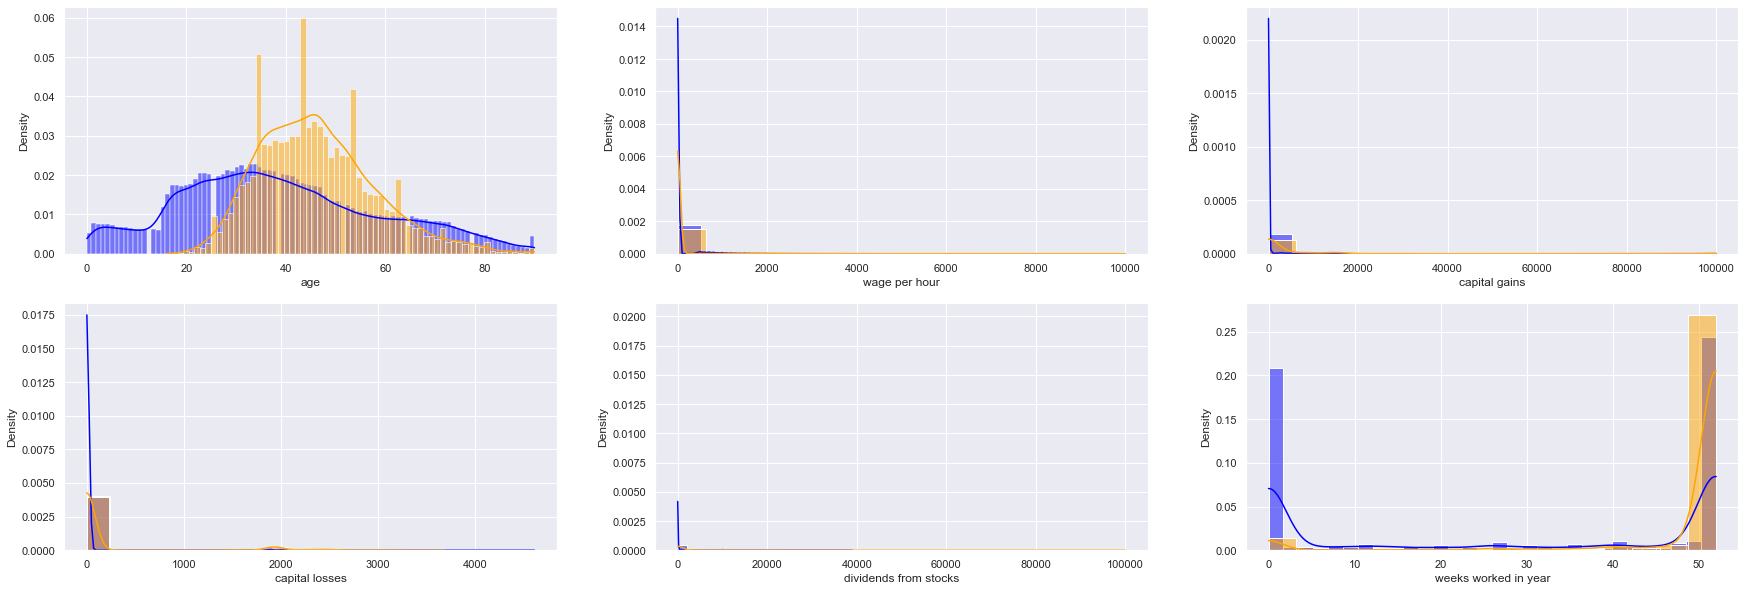

In [70]:
features_to_compare = [col for col in num_cols if col != "num persons worked for employer"]

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(30, 10))
for i, col in enumerate(features_to_compare):
    sns.histplot(data_under50, x=col, stat="density", kde=True, label="Under 50k", color="blue", ax=axs.flatten()[i])
    sns.histplot(data_over50, x=col, stat="density", kde=True, label="Over 50k", color="orange", ax=axs.flatten()[i])

We can make the following observations :

- **Age** : between 0 & ~20, the "under 50k" class is almost exclusively represented (which could be expected). On the other hand, for "middle range" ages, this variable does not seem to be able to discriminate (huge overlap)
- **Weeks worked in year** : as could also be expected, probability of being under 50k is much more important for individuals who did not work during the year. Aside from that, we can really say much more from the plot, because of overlap still
- **Other features** : the overwhelmingly high number of zeros makes it hard to conclude on a relationship. However, we could try converting them into binary classes ("not null"/"null") and look at heatmaps

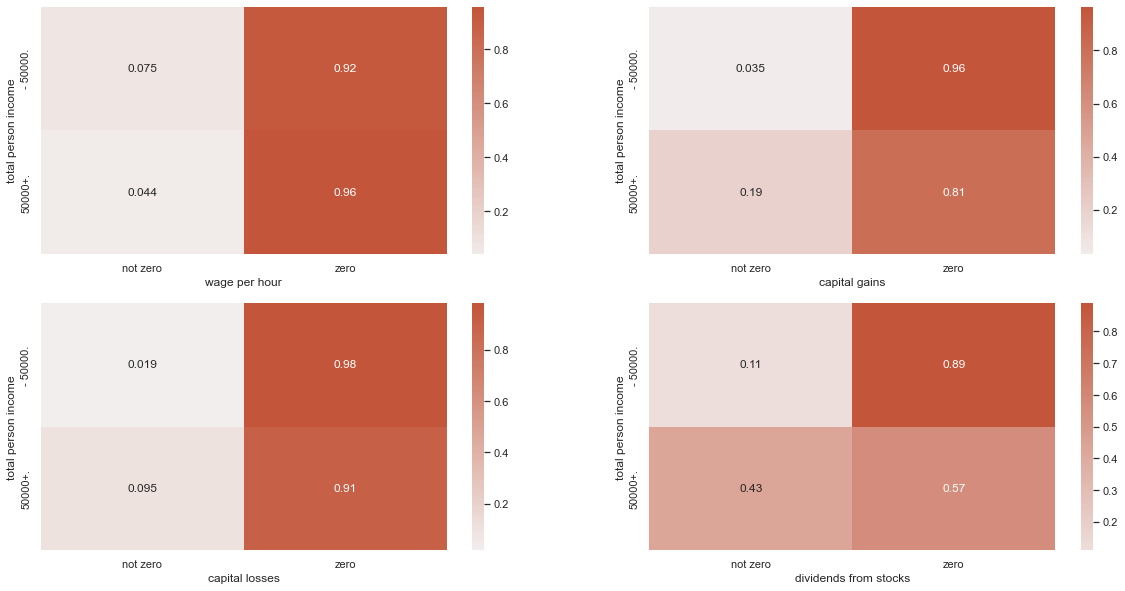

In [94]:
'''fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
for i, col in enumerate(["wage per hour", "capital gains", "capital losses", "dividends from stocks"]):
    sns.heatmap(pd.crosstab(data["total person income"], data[col].map(lambda val: "not zero" if val > 0 else "zero")), annot=True, fmt='d', ax=axs.flatten()[i], cmap=cmap, center=0)'''

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
for i, col in enumerate(["wage per hour", "capital gains", "capital losses", "dividends from stocks"]):
    tab = pd.crosstab(data["total person income"], data[col].map(lambda val: "not zero" if val > 0 else "zero"))
    tab = tab.apply(lambda row: row/row.sum(), axis=1)
    sns.heatmap(tab, annot=True, ax=axs.flatten()[i], cmap=cmap, center=0)

Because of heavy class imbalance, we looked at the proportion of each of the two categories **within each class**, rather than just counting occurences for each of the 4 combinations.

- From wage per hour and capital losses, we cannot conclude much.

- However, for capital gains and dividends from stocks, non-null values are significantly more frequent among the "high income" class

Let us now do the same for the rest of the categorical features

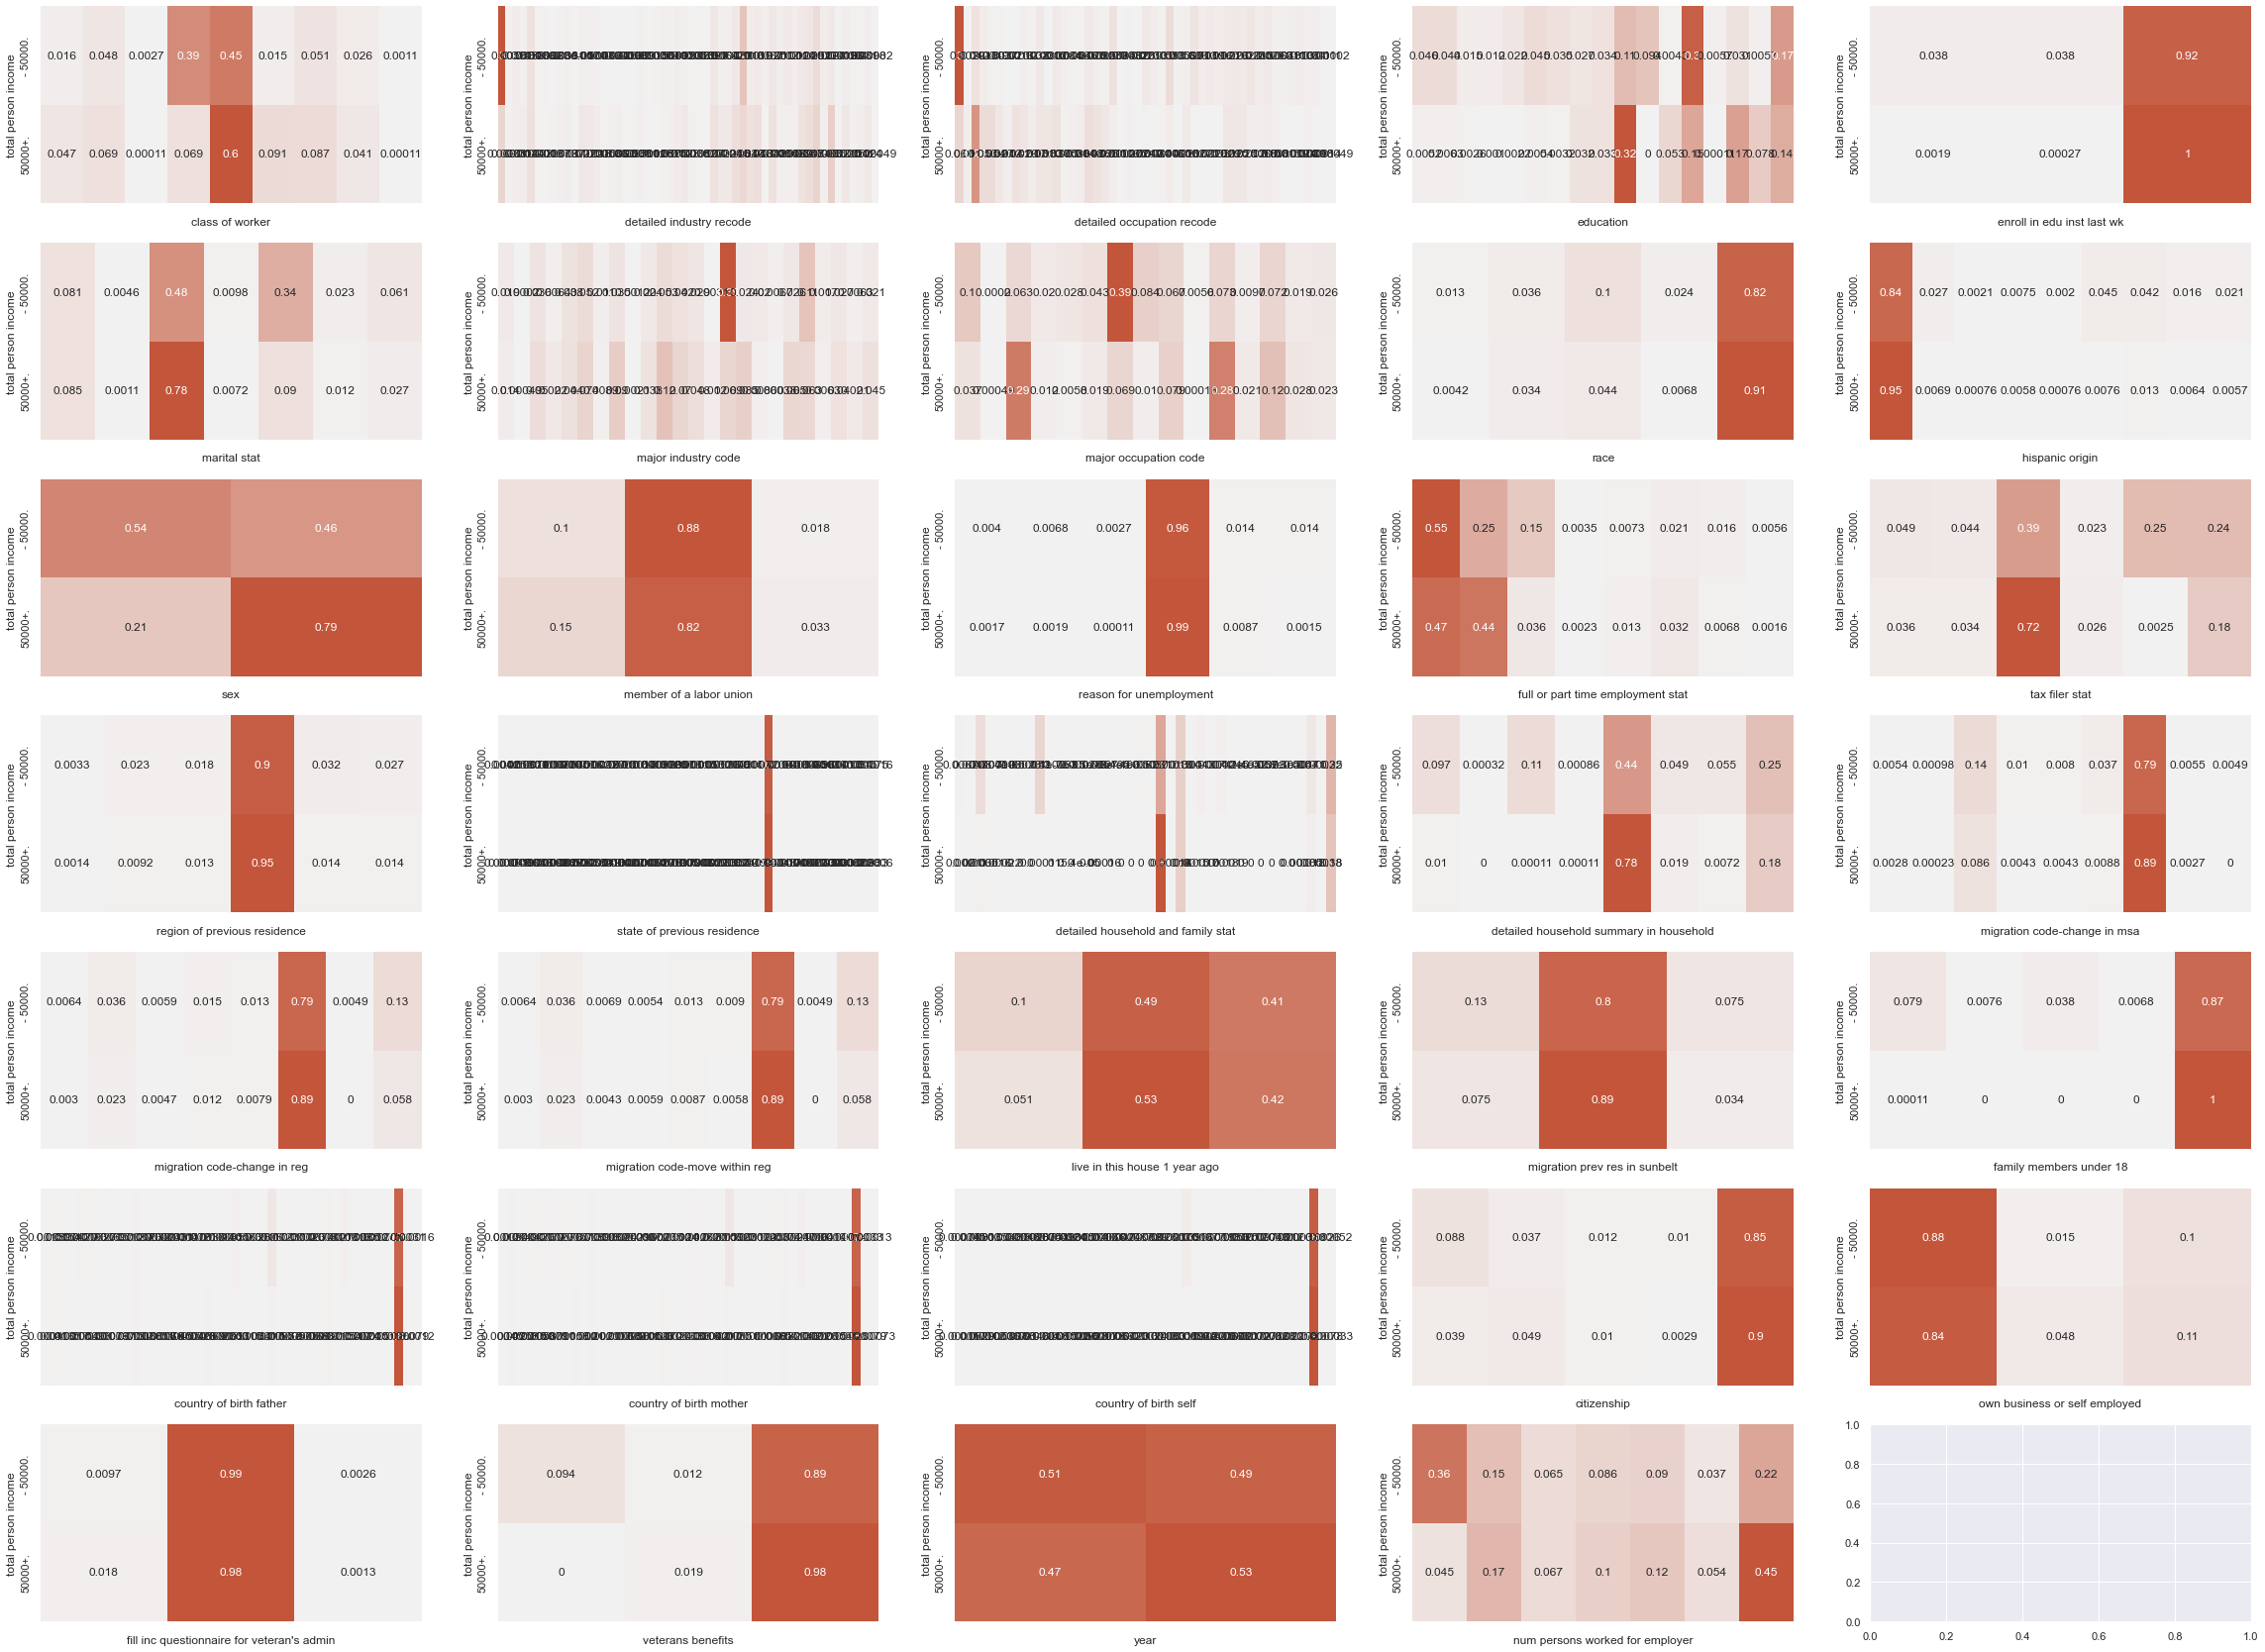

In [106]:
fig, axs = plt.subplots(nrows=7, ncols=5, figsize=(40, 30))
for i, col in enumerate(cat_cols + ["num persons worked for employer"]):
    tab = pd.crosstab(data["total person income"], data[col].astype("category"))
    tab = tab.apply(lambda row: row/row.sum(), axis=1)
    g = sns.heatmap(tab, annot=True, ax=axs.flatten()[i], cmap=cmap, center=0, cbar=False)
    g.set(xticklabels=[])
    

We can now divide these features into two groups :

- **Features with significant differences between the 2 classes distributions** : this seems to be the case for *[education, major industry code, major occupation code, num persons worked for employer]*. For these features, we can spot one or more high density points in one of the two classes matching low density in the other class. Therefore, they could be able to discriminate our target efficiently

- **All other features** : setting aside feature combinations, these in themselves do not carry much information

___
### Summing up features that could be dropped in pre-processing

- **Batch #1 : ~50% of missing values** : [migration code-change in msa, migration code-change in reg,migration code-move within reg, migration prev res in sunbelt]
- **Batch #2 : 2-4% of missing values** : [country of birth father, country of birth mother, country of birth self]
- **Batch #3 : <1% of missing values** : [hispanic origin, state of previous residence]
- **Batch #4 : many zeros continous distributions** : [wage per hour, capital gains, capital losses, dividends from stocks]
- **Batch #5 : extremely imbalanced categories** : [state of previous residence, country of birth father, country of birth mother, country of birth self, fill inc questionnaire for veteran’s admin]
